In [1]:
import cupy as cp
import numpy as np
import librosa as lb
import soundfile as sf
import matplotlib.pyplot as plt

import os, time, random

import numpy.typing as npt

from src.core.sequential import Sequential
from src.core.lstm import BiLSTM
from src.core.layers import Linear, SigmoidActivation, ReLU, sigmoid
from src.core.loss import MSELoss, SigmoidWeightedBCELoss, SigmoidWeightedBCEFocalLoss
from src.core.optimizers import Adam
from src.core.cosine_scheduler import CosineScheduler
from src.projects.noise_reduction.fourier_transform import compute_stft_vectorized, compute_stft_inv, convert_to_db, filter_downsample
from src.projects.noise_reduction.visualizations import plot_spectrogram, plot_loss_mask, plot_denoising_comparison
from src.utils.save_and_load_model import save_model, load_model
from src.utils.save_and_load_checkpoint import save_checkpoint, load_checkpoint

Tensor = npt.NDArray[cp.float64]

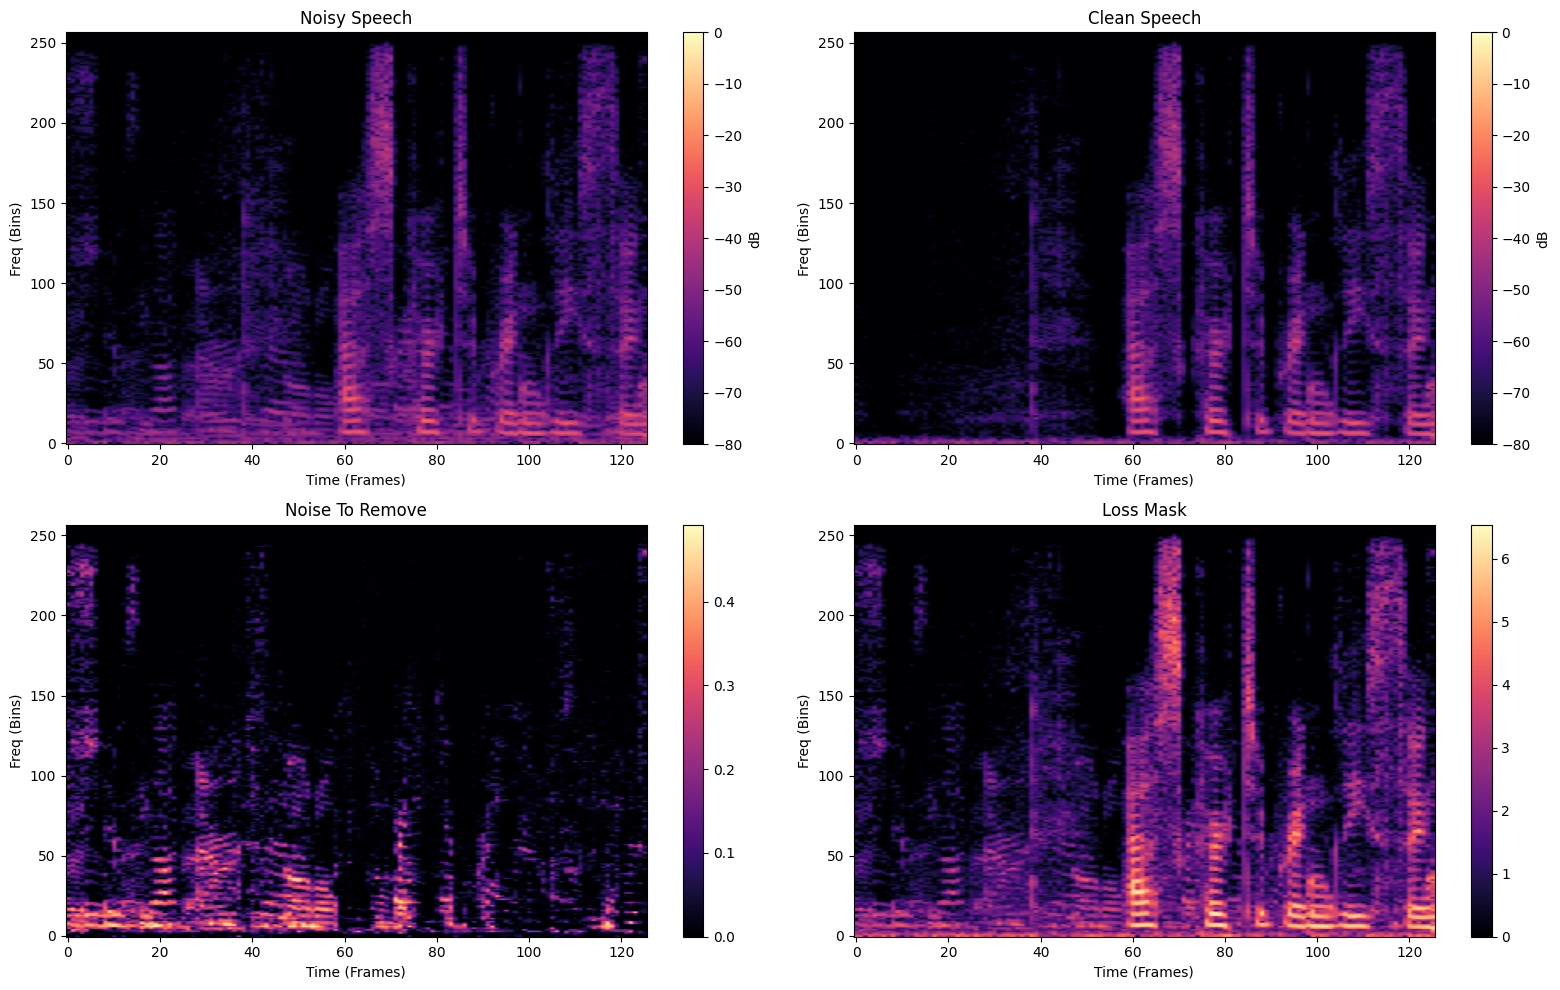

In [ ]:
noisy_path = r"D:\Datasets\Clean and Noisy Audio Dataset 16kHz Spectrogram Magnitudes\train\noisy\p234_002.npy"
clean_path = r"D:\Datasets\Clean and Noisy Audio Dataset 16kHz Spectrogram Magnitudes\train\clean\p234_002.npy"

# We already preprocessed the audios to 16kHz
sr, N, hop = 16000, 512, 256

n_spec = cp.load(noisy_path)
c_spec = cp.load(clean_path)

noisy_db = convert_to_db(n_spec, N, is_raw_magnitude=False).get()
clean_db = convert_to_db(c_spec, N, is_raw_magnitude=False).get()

plot_loss_mask(noisy_db, clean_db, save_path="src/projects/noise_reduction/tests/loss_mask.png")

In [3]:
class VoiceDataset:
    def __init__(self, path, duration, sr, N, hop, batch_size):
        self.duration = duration
        self.sr = sr
        self.N = N
        self.hop = hop
        self.batch_size = batch_size
        
        self.train_split = []
        self.val_split = []
        
        self.num_batches = {
            "train" : None,
            "val" : None
        }
        
        for split in ['train', 'val']:
            clean_dir_path = os.path.join(path, split, 'clean')
            noisy_dir_path = os.path.join(path, split, 'noisy')
            
            # We know the names are the same in both directories, same amount of files
            clean_files = sorted(os.listdir(clean_dir_path))
            noisy_files = sorted(os.listdir(noisy_dir_path))
            
            self.num_batches[split] = len(clean_files) // batch_size
            
            for batch_index in range(self.num_batches[split]):
                start = batch_index * batch_size
                end = start + batch_size
                
                batch_paths = []
                for i in range(start, end):
                    c_path = os.path.join(clean_dir_path, clean_files[i])
                    n_path = os.path.join(noisy_dir_path, noisy_files[i])
                    
                    batch_paths.append((c_path, n_path))
                    
                if split == "train":
                    self.train_split.append(batch_paths)
                elif split == 'val':
                    self.val_split.append(batch_paths)
                    
    def shuffle_train_data(self):
        all_training_paths = []
        
        for batch_index in range(self.num_batches['train']):
            all_training_paths.extend(self.train_split[batch_index])
            
        self.train_split = []
            
        random.shuffle(all_training_paths)
        
        for batch_index in range(self.num_batches['train']):
            start = batch_index * self.batch_size
            end = start + self.batch_size
            
            batch_paths = []
            
            for i in range(start, end):
                c_path, n_path = all_training_paths[i]
                
                batch_paths.append((c_path, n_path))
                
            self.train_split.append(batch_paths)
                        
    def get_batch(self, split='train', index=0):
        if split == 'train':
            batch_list = self.train_split[index]
        elif split == 'val':
            batch_list = self.val_split[index]
            
        X_batch, Y_batch, db_noisy_batch, db_clean_batch = [], [], [], [] # LM = Loss Mask

        for clean_path, noisy_path in batch_list:
            n_mag = cp.load(noisy_path)
            c_mag = cp.load(clean_path) 
            
            db_noisy = convert_to_db(n_mag, self.N, is_raw_magnitude=True)
            db_clean = convert_to_db(c_mag, self.N, is_raw_magnitude=True)
            
            # x_new = (x - center) / radius where center is (A + B) / 2 (center of original distribution, we center data around 0) and radius is (B - A) / 2 (how much the data is off 0 at most) 
            # x_input = (x_input - (-100 + 0) / 2) / ((0 - (-100)) / 2) # bc our [A, B] is [-100, 0]
            x_input = (db_noisy + 40) / 40 # Same as line above
            x_input = cp.clip(x_input, -1.0, 1.0, out=x_input) # We clip if the magnitude in convert_to_db was bigger than 1

            mask = c_mag / (n_mag + 1e-9) # target_mask = cp.abs(clean) / cp.abs(noisy) -> this means "how much of clean signal is in the noisy?" If its 100% then its 1, if 0% then 0.
            mask = cp.clip(mask, 0, 1, mask)
            
            X_batch.append(x_input)
            Y_batch.append(mask)
            db_noisy_batch.append(db_noisy)
            db_clean_batch.append(db_clean)
            
        X_stack, Y_stack, LM_stack = cp.stack(X_batch), cp.stack(Y_batch), (cp.stack(db_noisy_batch), cp.stack(db_clean_batch))
            
        del X_batch, Y_batch, db_noisy_batch, db_clean_batch
        
        return X_stack, Y_stack, LM_stack
    
    def summary(self):
        print(f"Train batches: {self.num_batches['train']}")
        print(f"Validation batches: {self.num_batches['val']}")

In [4]:
dataset_path = r"D:\Datasets\Clean and Noisy Audio Dataset 16kHz Spectrogram Magnitudes"
duration = 2 # 2 sec per sample, if less we pad
sampling_rate = 16000
N, hop = 512, 256
batch_size = 128

input_dim = N // 2 + 1 # amount of bins
hidden_dim = 256 # for BiLSTM its 256 * 2 = 512 theoretically
dense_dim = 512
output_dim = N // 2 + 1 # also amount of bins (the mask)

max_lr = 1e-3
min_lr = 1e-5
warmup_epochs = 0
total_epochs = 120

gamma = 0.25

dataset = VoiceDataset(dataset_path, sampling_rate, duration, N, hop, batch_size)

model = Sequential([
    BiLSTM(input_dim, hidden_dim),
    Linear(2 * hidden_dim, output_dim, act='sigmoid'), # Because outputs are returned reshapes, we can apply two times with flattening logic.
])

loss_fn = SigmoidWeightedBCEFocalLoss(gamma)

params = model.params()
optimizer = Adam(params, max_lr, beta1=0.9, beta2=0.999, eps=1e-8)
scheduler = CosineScheduler(max_lr, min_lr, warmup_epochs, total_epochs)

learnable_layers = {
    "model" : model
}

model.summary()
dataset.summary()

Total trainable parameters: 1184513
Train batches: 180
Validation batches: 6


In [ ]:
checkpoint_path = 'models/best_denoise_focal.npz'
resume_training = False
print_every = 100

start_epoch = 1
best_loss = float('inf')
train_loss_history = []
val_loss_history = []

if resume_training:
    start_epoch, best_loss, train_loss_history, val_loss_history = load_checkpoint(checkpoint_path, learnable_layers, optimizer)
    start_epoch += 1 # We resume from one further than when we saved
    
for epoch in range(start_epoch, total_epochs+1):
    learning_rate = scheduler.get_lr(epoch)
    
    epoch_train_losses = []
    epoch_val_losses = []
    
    start_time = time.time()
    # Train
    for batch_index in range(dataset.num_batches['train']):
        
        X_batch, Y_batch, (db_noisy, db_clean) = dataset.get_batch('train', batch_index)
        
        speech_to_keep = (db_clean + 80) / 80 # scale to [0, 1]
        speech_to_keep = cp.clip(speech_to_keep, 0, 1) # How much we want to keep it
        noise_to_delete = cp.clip(db_noisy - db_clean, 0, 80) / 80 # How much we want to zero it out
        
        loss_mask = cp.maximum(speech_to_keep, noise_to_delete) # take max of masks
        loss_mask = loss_mask / cp.mean(loss_mask) # normalization drives important pixels even higher
        

        logits = model.forward(X_batch)
        loss, mask = loss_fn.forward(logits, Y_batch, loss_mask)
        
        epoch_train_losses.append(loss.get())
        
        dlogits = loss_fn.backward()
        dinput = model.backward(dlogits)
        
        optimizer.step(learning_rate)
        
        if (batch_index + 1) % print_every == 0 or batch_index == 0: # Print the first batch too
            end_time = time.time()
            diff = end_time - start_time
            
            total_steps = total_epochs * dataset.num_batches['train']
            completed_steps = ((epoch - 1) * dataset.num_batches['train']) + (batch_index + 1) 
            progress = completed_steps / total_steps * 100
            
            print_train_loss = np.mean(epoch_train_losses[-print_every:]) if batch_index != 0 else epoch_train_losses[0]
            bpm = 60 / diff * print_every if batch_index != 0 else 60 / diff
            print(f"Epoch: {epoch} | Batch: {batch_index+1} | Loss: {np.mean(epoch_train_losses):.6f} | BPM: {bpm:.2f} batches | Progress: {progress:.2f}%")
            print(f"Mask max: {cp.max(mask)} | Mask min: {cp.min(mask)}")
            
            start_time = time.time()
    
    # Eval
    for batch_index in range(dataset.num_batches['val']):
        start_time = time.time()
        
        X_batch, Y_batch, (db_noisy, db_clean) = dataset.get_batch('val', batch_index)
        
        speech_to_keep = (db_clean + 80) / 80 # same as in training loop
        speech_to_keep = cp.clip(speech_to_keep, 0, 1) 
        noise_to_delete = cp.clip(db_noisy - db_clean, 0, 80) / 80 
        
        loss_mask = cp.maximum(speech_to_keep, noise_to_delete) 
        loss_mask = loss_mask / cp.mean(loss_mask)
        
        logits = model.forward(X_batch)
        loss, mask = loss_fn.forward(logits, Y_batch, loss_mask)
        
        epoch_val_losses.append(loss.get())
    
    ave_train_loss = np.mean(epoch_train_losses)
    ave_val_loss = np.mean(epoch_val_losses)
    
    train_loss_history.append(ave_train_loss) # already Numpy
    val_loss_history.append(ave_val_loss) # same
    
    print(f"Finished epoch {epoch}. Training Loss: {np.mean(ave_train_loss):.6f} Val Loss: {np.mean(ave_val_loss):.6f}")
    
    if ave_val_loss < best_loss: # pick based on validation
        best_loss = ave_val_loss
        save_checkpoint(checkpoint_path, learnable_layers, optimizer, epoch, best_loss, train_loss_history, val_loss_history)
        
    dataset.shuffle_train_data()

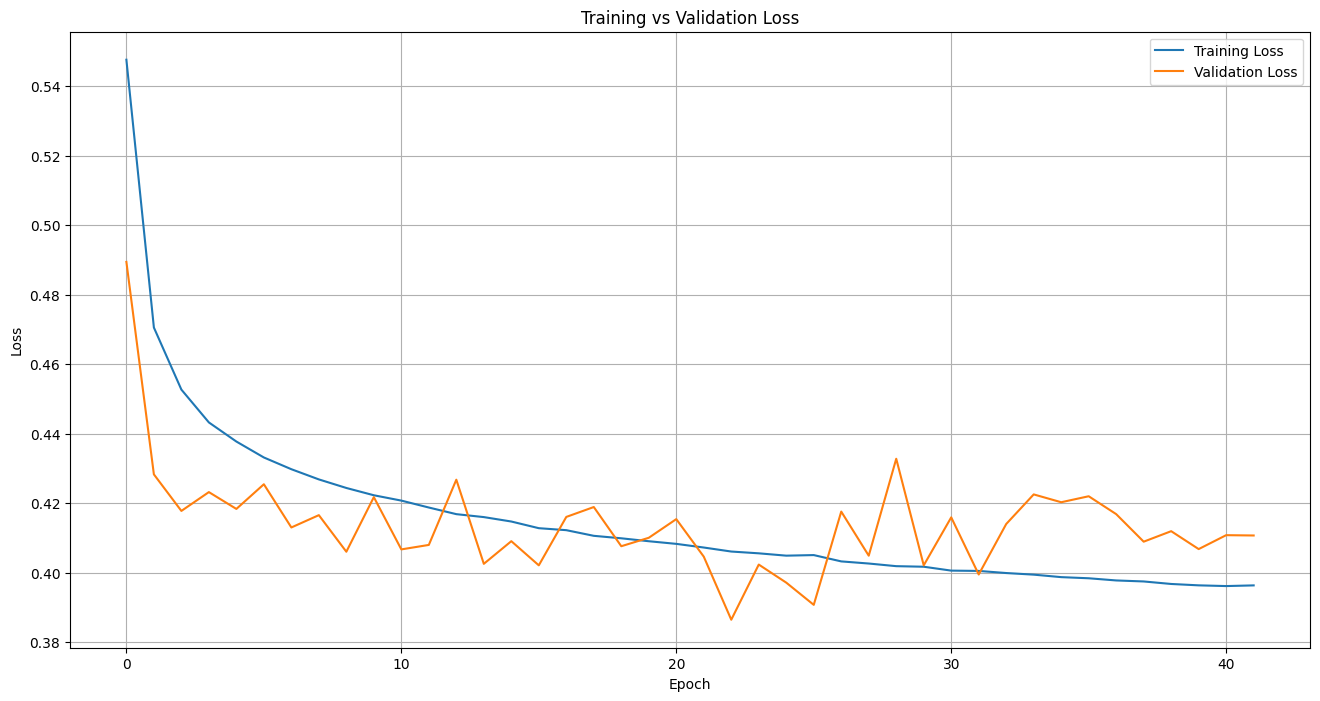

In [ ]:
save_loss_plot = True

plt.figure(figsize=(16 ,8))

plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')

plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

if save_loss_plot:
    plt.savefig("src/projects/noise_reduction/tests/training_val_loss.png")

plt.show()

In [7]:
def clean_recording(audio: Tensor, N: int, hop: int, model: Sequential):

    spec, orig_len = compute_stft_vectorized(audio, N, hop) # (num_frames, K), we need orig_len to reverse the padding
    mag = convert_to_db(spec, N, is_raw_magnitude=False) # (num_frames, K)
    
    mag_norm = (mag + 40) / 40 # Same normalization as training as data ranges between (-80, 0)
    mag_norm = cp.clip(mag_norm, -1.0, 1.0) # safety clip

    logits = model.forward(mag_norm[cp.newaxis, :, :]).squeeze() # add new axis for B=1
    mask = sigmoid(logits)
    
    cleaned_spec = spec * mask # scales imaginary and real components accordingly (just the magnitude)
    audio = compute_stft_inv(cleaned_spec, orig_len, N, hop)
    
    return audio, mask

In [8]:
best_model_path = "models/best_denoise_focal.npz"
load_model(best_model_path, learnable_layers)

Successfully loaded model from models/best_denoise_focal.npz


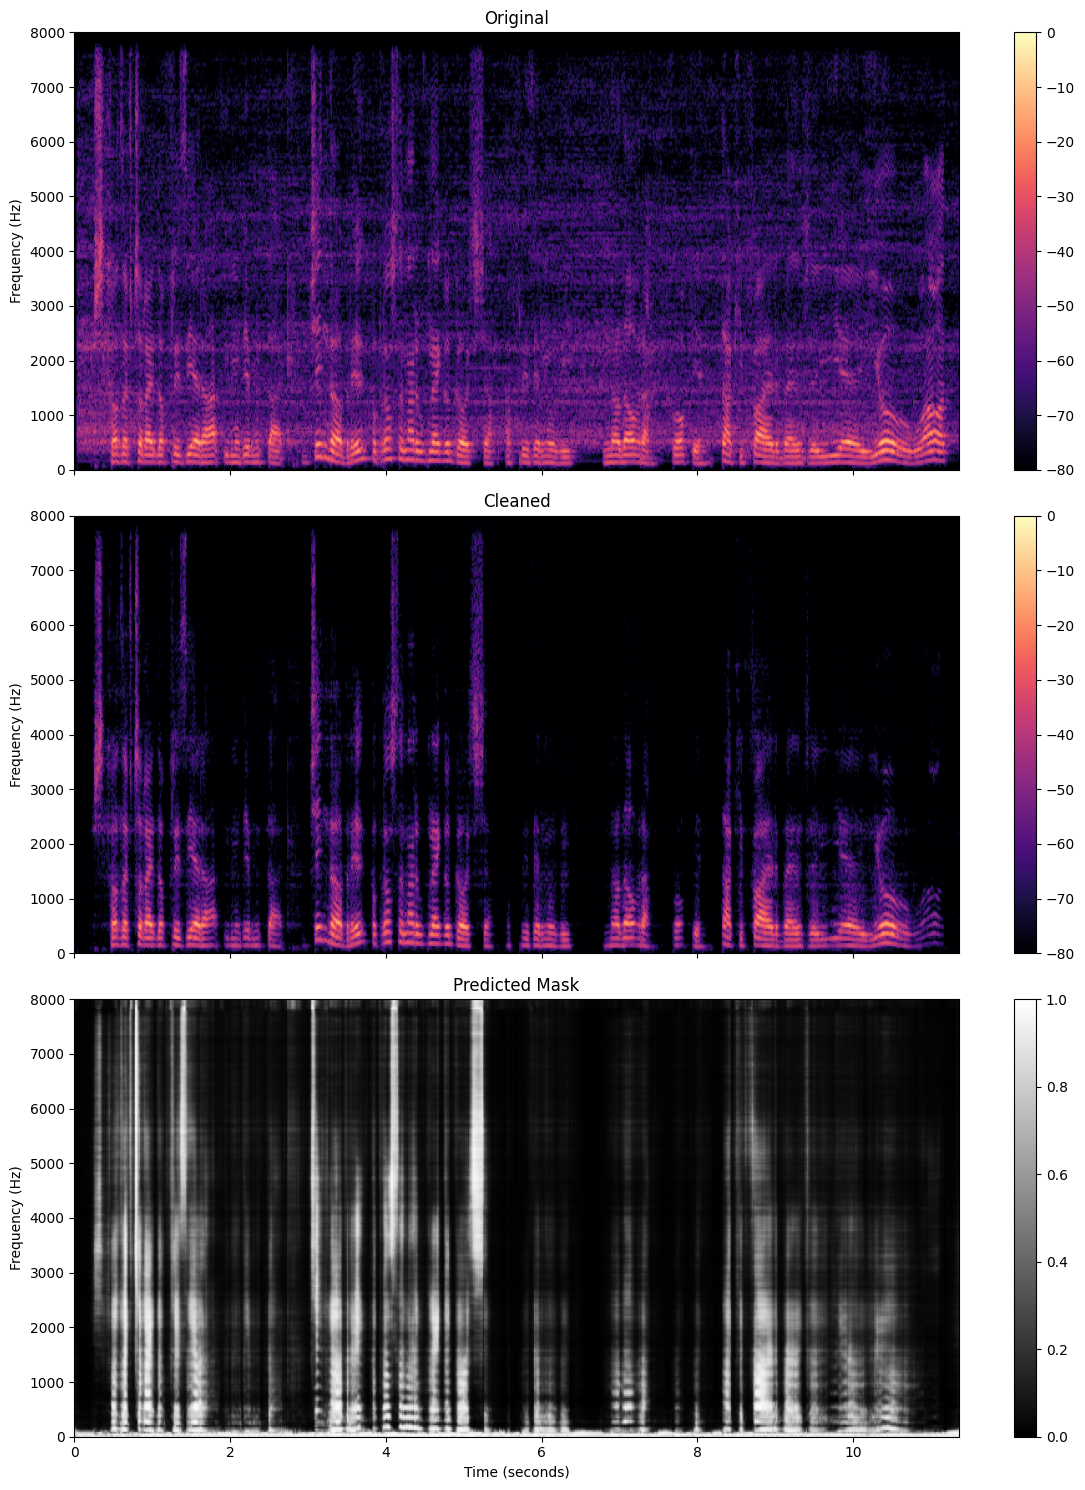

Saved audio to: C:\Users\horec\Downloads\clean_sample.wav


In [ ]:
noisy_audio_path = r"C:\Users\horec\Downloads\noisy_sample.wav"
output_audio_path = r"C:\Users\horec\Downloads\clean_sample.wav"

noisy_audio, _ = lb.load(noisy_audio_path, sr=sampling_rate)
clean_audio, mask = clean_recording(noisy_audio, N, hop, model)

n_spec, _ = compute_stft_vectorized(noisy_audio, N, hop) # both are in the complex plane
c_spec, _ = compute_stft_vectorized(clean_audio, N, hop)

plot_denoising_comparison(n_spec, c_spec, mask.get(), sampling_rate, N, hop, save_path="src/projects/noise_reduction/tests/denoising_comparison.png")

sf.write(output_audio_path, clean_audio.get(), sampling_rate)
print(f"Saved audio to: {output_audio_path}")